In [102]:
%reload_ext autoreload
%autoreload 2 
import numpy as np
import matplotlib.pyplot as plt  

from env import SingleStateSpace 
from env import DoubleStateSpace
from RewardFunctions import SingleStateReward
from RewardFunctions import DoubleStateReward

from policy_walk import PolicyWalk 
from priors import UniformPrior 
from priors import TimeDependentPrior

from generate_trajectory import generate_trajectory
from policy import Boltzmann 
from learn import policy_iteration

In [103]:
#Set up the environment
trajectory_length = 20
env = SingleStateSpace(n_actions = 10, discount_rate = 0.1, R_max = 5)
# env = DoubleStateSpace(n_actions=10, discount_rate = 0.1)

#generate observation times 
observation_times = np.cumsum(np.random.uniform(0, 2, size=trajectory_length))

#Create a matrix for the true rewards 
s_grid, a_grid, t_grid = np.meshgrid(env.states, env.actions, observation_times, indexing='ij')
R = np.vectorize(env.reward)(s_grid,a_grid,t_grid)

#Find the optimal policy, values and q_values for the true reward to generate the trajectory. 
alpha = 1
(optimal_pi, optimal_values, optimal_q_values) = policy_iteration(env,trajectory_length,R)
b = Boltzmann(optimal_q_values, env.actions, alpha = alpha)

#multiple trajectories are combined - just means that the agent does multiple things at each time slot to allow for more data to be gathered
observations = generate_trajectory(env,b,observation_times, n_trajectories=10) 
# step_size = 0.005
step_size = 0.035

prior = TimeDependentPrior(observation_times, R_max = 5, sigma = 0.5)
pw = PolicyWalk(env,prior,observations,observation_times,alpha)
learned_rewards, acceptance_probs = pw.get_samples(step_size, n_iters = 100000)
policy_walk_iters = 1
for _ in range(policy_walk_iters-1): 
    learned_rewards = np.concatenate((learned_rewards, pw.get_samples(step_size, n_iters = 100000)))

In [82]:
learned_rewards, acceptance_probs = policy_walk(env,observations,observation_times,step_size = step_size,n_iters=100000, alpha = alpha)
policy_walk_iters = 1

In [ ]:
#Run profiling on policy walk 
import cProfile
import re 
cProfile.run('re.compile(policy_walk(env,observations,observation_times,step_size = step_size,n_iters=10000, alpha = alpha))')

Analysis of Acceptance Probabilities:

0.3202856465656697


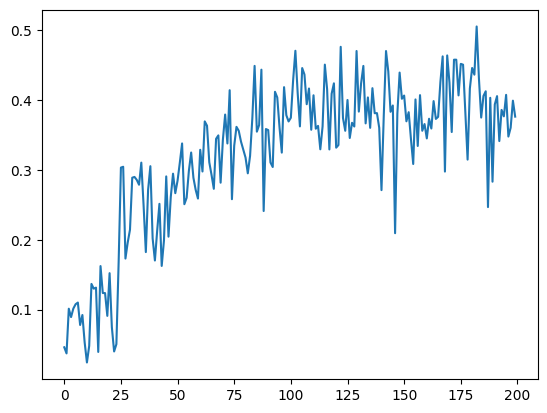

In [104]:
#Scatter plot of thinned acceptance probabilities - change policy_walk to return acceptance probabilities to use
print(np.average(acceptance_probs))
# plt.scatter(range(len(acceptance_probs[14::15])), acceptance_probs[14::15])
# plt.show()

# Moving average of acceptance probabilities
import math
window_size = 500
n_windows = math.floor(len(acceptance_probs)/window_size) 
averages = [] 
for i in range(n_windows): 
    averages.append(np.average(acceptance_probs[window_size*i:window_size*(i+1)]))
plt.plot(averages)
plt.show() 


Analysis of Average Learned Reward Matrix

[ 1.95649264  3.16445326  4.67728454  6.63952688  8.29688054  8.54959087
  9.05685291 10.81955945 12.28750938 13.27418659 14.99541791 15.53636669
 15.9429798  16.35146553 17.00614882 18.98616125 19.25281295 19.58273492
 21.30102614 22.31146226]


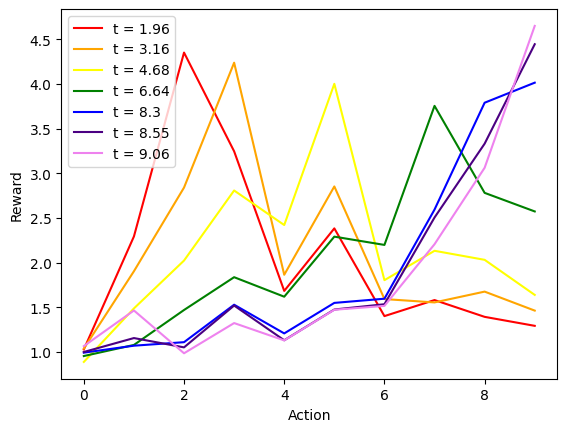

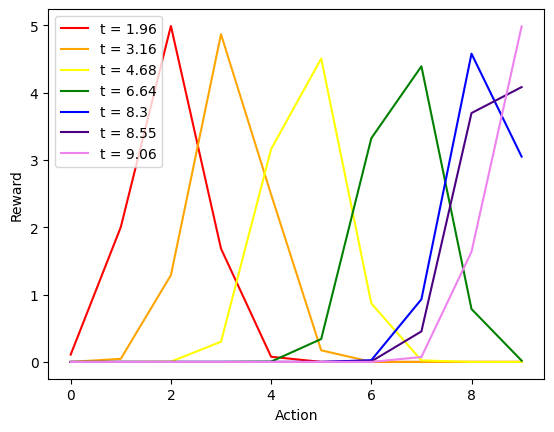

In [105]:
#Shows hte overall learned rewards - switch to the bigger colors array to view all 
# colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
avg_reward = np.average(np.asarray(learned_rewards[37500:]),axis = 0)
print(observation_times)
s = 0
T = 7
colors = ["red", "orange","yellow","green","blue","indigo","violet"]
for t in range(T):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(avg_reward[s,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

for t in range(T):
    label = "t = " + format(round(observation_times[t],2))
    plt.plot(R[s,:,t], color=colors[t], label = label)
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.show()

Chain Analysis

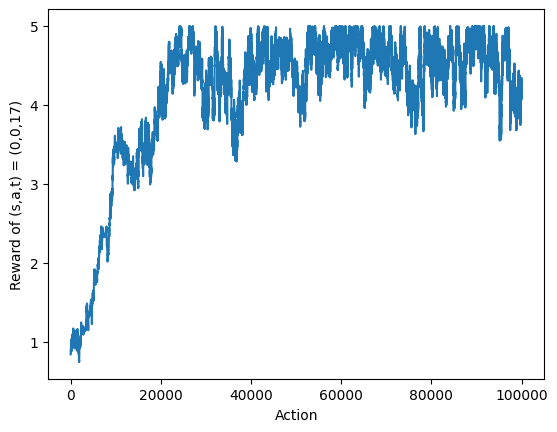

In [78]:
#Used to analyse individual chains: 
# print(observations)

#Plot a single reward
s,a,t = 0,0,17
plt.plot(learned_rewards[:,s,a,t])
ylabel = "Reward of (s,a,t) = (" + format(s) + "," + format(a) + "," + format(t) + ")"
plt.ylabel(ylabel)
plt.xlabel("Action")
plt.show()

In [95]:
def test():
    for _ in range(1000000):
        x = np.random.rand(20) 
        assert(np.dot(x,x) == np.matmul(np.matmul(x.T,np.eye(20)),x))

# #Run profiling on policy walk 
# import cProfile
# import re 
# cProfile.run('test()')

[[0, 1, 0], [0, 2, 1], [0, 3, 2], [0, 4, 3], [0, 6, 4], [0, 1, 5], [0, 8, 6], [0, 5, 7], [0, 9, 8], [0, 9, 9], [0, 7, 10], [0, 5, 11], [0, 5, 12], [0, 3, 13], [0, 3, 14], [0, 2, 15], [0, 0, 16], [0, 0, 17], [0, 0, 18], [0, 2, 19], [0, 1, 0], [0, 2, 1], [0, 3, 2], [0, 4, 3], [0, 6, 4], [0, 7, 5], [0, 9, 6], [0, 3, 7], [0, 9, 8], [0, 9, 9], [0, 7, 10], [0, 6, 11], [0, 4, 12], [0, 4, 13], [0, 3, 14], [0, 1, 15], [0, 0, 16], [0, 0, 17], [0, 0, 18], [0, 2, 19], [0, 1, 0], [0, 2, 1], [0, 4, 2], [0, 5, 3], [0, 6, 4], [0, 7, 5], [0, 8, 6], [0, 8, 7], [0, 1, 8], [0, 2, 9], [0, 7, 10], [0, 7, 11], [0, 5, 12], [0, 3, 13], [0, 3, 14], [0, 2, 15], [0, 0, 16], [0, 0, 17], [0, 1, 18], [0, 0, 19], [0, 1, 0], [0, 2, 1], [0, 4, 2], [0, 4, 3], [0, 6, 4], [0, 6, 5], [0, 8, 6], [0, 9, 7], [0, 3, 8], [0, 9, 9], [0, 7, 10], [0, 6, 11], [0, 5, 12], [0, 4, 13], [0, 3, 14], [0, 2, 15], [0, 0, 16], [0, 5, 17], [0, 0, 18], [0, 3, 19], [0, 1, 0], [0, 2, 1], [0, 3, 2], [0, 5, 3], [0, 5, 4], [0, 0, 5], [0, 8, 6], [0

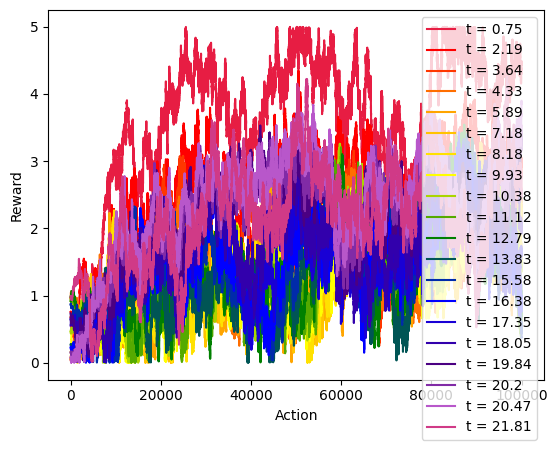

<Figure size 1600x1600 with 0 Axes>

In [90]:
#Plot rewards over time for a given state/action pair - shows observed (s,a,t) pairs in colour 
print(observations)
s,a, = 0,1
# s,t = 0,5
colors = ["#e71d43","#ff0000","#ff3700","#ff6e00","#ffa500","#ffc300","#ffe100","#ffff00","#aad500","#55aa00","#008000","#005555","#002baa","#0000ff","#1900d5","#3200ac","#4b0082","#812ba6","#b857ca","#d03a87"]
for t in range(20):
    label = "t = " + format(round(observation_times[t],2))
    # if [s,a,t] in observations: 
    plt.plot(learned_rewards[:,s,a,t], color=colors[t], label = label)
    # else:
        # plt.plot(learned_rewards[:,s,a,t], color="grey", label = label)        
    
plt.ylabel("Reward")
plt.xlabel("Action")
plt.legend()
plt.figure(figsize=(10,10), dpi=160)
plt.show()

Histogram Plots:

In [ ]:
converged_rewards = learned_rewards[37500:]
print(observation_times)
s,a,t = 0,0,0
for t in range(20):
    plt.hist(converged_rewards[:,s,a,t],bins = 20,color=colors[t])
    plt.show()